<a href="https://colab.research.google.com/github/keerthanab2201/Sentiment-Analysis-using-Deep-Learning/blob/main/sentiment_analysis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Collection
(E-Commerce product reviews from Amazon in JSON format)

In [1]:
import pandas as pd

In [2]:
# load csv file and preview
df= pd.read_csv("/content/drive/MyDrive/datasets/Amazon-Product-Reviews-Sentiment-Analysis-in-Python-Dataset.csv")
print(df.head())

                                              Review  Sentiment
0  Fast shipping but this product is very cheaply...          1
1  This case takes so long to ship and it's not e...          1
2  Good for not droids. Not good for iPhones. You...          1
3  The cable was not compatible between my macboo...          1
4  The case is nice but did not have a glow light...          1


In [3]:
# Save as a JSON file(records format)
df.to_json("amazon_reviews_data.json", orient="records", lines=True)
print("✅ Conversion complete: Saved as reviews_data.json")

✅ Conversion complete: Saved as reviews_data.json


##Data Pre-Processing
- lowercase
- stopword removal
- punctuation removal
- one word review removal
- contraction removal
- tokenization
- part of speech tagging

In [4]:
# installing dependencies
!pip install contractions textblob gensim beautifulsoup4
!python -m textblob.download_corpora

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
# Step 2: Import Modules
import re
import pandas as pd
import nltk
import numpy as np
import gensim
from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from contractions import fix as expand_contractions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [6]:
# load JSON dataset and inspect columns
df = pd.read_json("amazon_reviews_data.json", lines=True)
print(df.columns)


Index(['Review', 'Sentiment'], dtype='object')


In [7]:
# Drop missing values and filter required columns
text_col = "Review"
label_col = "Sentiment"
df = df[[text_col, label_col]].dropna() #these are the two columns
df.columns = ["text", "rating"]  # Normalize column names

In [8]:
stop_words = set(stopwords.words("english"))

In [9]:
# Define preprocessing function
def preprocess_pipeline(text):
    text = str(text)

    # 1. Lowercasing
    text = text.lower()

    # 2. Stopword Removal
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]

    # 3. Remove Punctuation
    tokens = [re.sub(r"[^\w\s]", "", t) for t in tokens]
    tokens = [t for t in tokens if t.strip() != ""]

    # Rejoin tokens for further steps
    text = " ".join(tokens)

    # 4. Remove One-Word Reviews
    if len(tokens) <= 1:
        return None

    # 5. Contraction Removal
    text = expand_contractions(text)

    # 6. Tokenization (again)
    tokens = word_tokenize(text)

    # 7. Part-of-Speech (POS) Tagging
    pos_tags = nltk.pos_tag(tokens)

    # 8. Score Generation using TextBlob Sentiment
    polarity_score = TextBlob(text).sentiment.polarity  # -1 to 1

    return {
        "clean_text": text,
        "tokens": tokens,
        "pos_tags": pos_tags,
        "score": polarity_score
    }

In [10]:
# Apply preprocessing function

processed = df["text"].apply(preprocess_pipeline)
df = df[processed.notnull()].copy()
df["processed"] = processed[processed.notnull()].values



In [11]:
# Extract data for tokenization
texts = df["processed"].apply(lambda x: x["clean_text"]).tolist()
labels = df["rating"].tolist()
scores = df["processed"].apply(lambda x: x["score"]).tolist()

In [12]:
# 9. Word Embeddings
#Keras Tokenizer + Sequence Padding
MAX_VOCAB = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post')


In [13]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/glove.6B.zip", "r") as zip_ref:
    zip_ref.extractall("glove")

In [14]:
# Step 7: Load GloVe and Create Embedding Matrix

embedding_index = {}
with open("glove/glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")[:50]  # ← Truncate to 50D
        embedding_index[word] = coefs

embedding_dim = 50  # matching model spec
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


##CNN Model

In [15]:
# Step 1: Drop neutral reviews and relabel
df = df[df['rating'] != 3]
df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

/tmp/ipython-input-15-3384147470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)


In [16]:
# Step 2: Get cleaned texts again
texts = df["processed"].apply(lambda x: x["clean_text"]).tolist()
labels = df["label"].tolist()

In [17]:
# Step 3: Tokenize and pad again
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=400, padding='post')

In [18]:
# prepare tokenizer and sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [19]:
vocab_size = 15000
input_length = 400

In [20]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
padded_sequences = pad_sequences(sequences, maxlen=input_length, padding='post')

word_index = tokenizer.word_index

In [25]:
embedding_dim = 50
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [28]:
# assign hyperparameters
embedding_dim = 50
num_filters = 64
kernel_size = 3
strides = 5
pool_size = 5
dropout_rate = 0.4

In [29]:
# build CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=len(word_index)+1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix[:, :embedding_dim]],
                        input_length=input_length,
                        trainable=False))
cnn_model.add(Conv1D(filters=64, kernel_size=3, strides=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=5))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))  # Binary output

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [31]:
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)


In [32]:
# Step 6: Train the Model
history = cnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_test, y_test)
)



Epoch 1/5
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5933 - loss: 0.6651 - val_accuracy: 0.7307 - val_loss: 0.5462
Epoch 2/5
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7062 - loss: 0.5604 - val_accuracy: 0.7488 - val_loss: 0.5154
Epoch 3/5
491/491 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7379 - loss: 0.5262 - val_accuracy: 0.7511 - val_loss: 0.5039
Epoch 4/5
491/491 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7599 - loss: 0.4974 - val_accuracy: 0.7656 - val_loss: 0.4885
Epoch 5/5
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7718 - loss: 0.4746 - val_accuracy: 0.7671 - val_loss: 0.4837


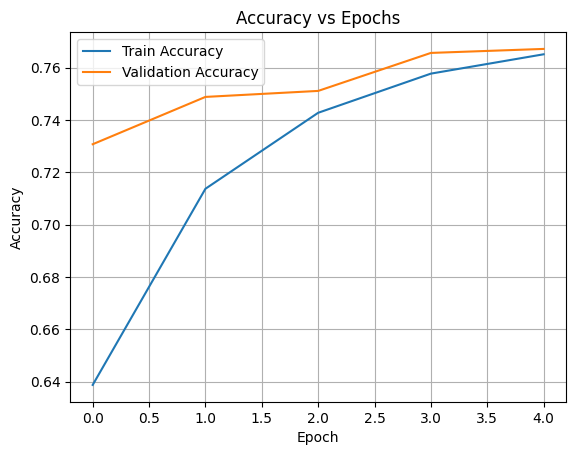

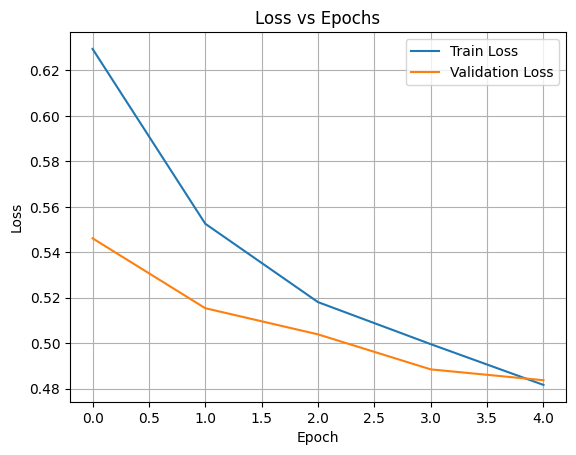

In [33]:
# plot accuracy and loss vs epoch
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, np.array(labels), test_size=0.2, random_state=42)


In [36]:
# Predict probabilities on test set
y_pred_prob = cnn_model.predict(X_test)

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion matrix and specificity
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# Print results
print("Confusion Matrix:")
print(cm)
print(f"\nAccuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Specificity  : {specificity:.4f}")


Confusion Matrix:
[[1616  376]
 [ 538 1395]]

Accuracy     : 0.7671
Precision    : 0.7877
Recall       : 0.7217
F1 Score     : 0.7532
Specificity  : 0.8112
